In [ ]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'ConSTRain-analyses' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

In [4]:
vcf = "../../../data/HG002/variants/ConSTRain/v0.9.1/HG002.GRCh38.2x250_with_mononuc.vcf" # str: path to input vcf file                      
vcf_format = "ConSTRain" # str: which tool was used to genotype
sample = "HG002.GRCh38.2x250" # str: name of sample in vcf to analyse
set_cn = False # bool: set CN of loci manually (based on chromosome name)
gt_in_bp = False # bool: does the tool report genotypes in bp (True) or in number of repeat units (False)
strs_covered_by_haplotypes = "../../../data/HG002/regions/hg38_ver13_0boe_mononucleotides_union.bed" # str: path to bed with loci that are covered by the haplotypes provided by Q100
haplotype_str_length = "../../../data/HG002/variants/HG002_GRCh38_STR_lengths.csv" # str: path to csv with STR allele lengths based on Q100 haplotypes
comparison_file_out = "../../../results/HG002/2024-12-09_hg002_ConSTRain0.9.1.csv" # None or str: path to write csv with comparison of STR allele lengths from vcf to Q100 STR allele lengths

# depth_filter = 0.05 # None or float. Alpha to use for filtering loci with extreme depth values
lower, upper = None, None
filt_segdup = False

In [5]:
def set_cn_manually(df):
    autosomes = [f"chr{i}" for i in range(1, 23)]
    df = df.assign(
        copy_number = lambda x: [2 if i in autosomes else 1 for i in x["chr"]]
    )
    return df

In [6]:
df_repeats, df_hg002 = file_io.dfs_from_vcf(filename=vcf, samples=[sample], vcf_format=vcf_format)
df_hg002 = df_hg002.dropna().assign(
    depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    depth_norm = lambda x: x["depth"] / x["copy_number"]
).reset_index(drop=True)
df_hg002 = df_hg002.merge(df_repeats[["str_id", "period"]], on="str_id", how="left")
print(df_repeats.shape, df_hg002.shape)


(1733646, 7) (1683696, 8)


In [7]:
1465953 - 1464386 # exactly the same as the number of AMBGT filter tags in the VCF

1567

In [8]:
if lower and upper:
    print(df_hg002.shape)
    df_hg002 = df_hg002.query(f"depth_norm >= {lower} and depth_norm <= {upper}").reset_index(drop=True)
    print(df_hg002.shape)
    

In [9]:
df_covered_repeats = pd.read_csv(strs_covered_by_haplotypes, sep="\t", names=["chr", "start", "end", "period", "unit"])
df_covered_repeats = df_covered_repeats.assign(
            str_id = np.array([f"{chrom}_{start + 1}" for chrom, start in zip(df_covered_repeats.chr, df_covered_repeats.start)])
)

df_covered_repeats = df_repeats[df_repeats["str_id"].isin(df_covered_repeats["str_id"])]

df_hg002 = df_hg002.merge(
    df_covered_repeats[["str_id", "chr", "start", "end", "unit", "ref"]], on="str_id", how="inner"
)

if set_cn:
    df_hg002 = set_cn_manually(df_hg002)
    
df_hg002 = df_hg002.dropna().reset_index(drop=True)

print(df_covered_repeats.shape, df_hg002.shape)

df_hg002

(1695865, 7) (1655655, 13)


,sample,str_id,copy_number,frequencies,genotype,depth,depth_norm,period,chr,start,end,unit,ref
0,HG002.GRCh38.2x250,chr1_588068,2,{4: 22},"[4, 4]",22,11.0,3,chr1,588068,588079,CCT,4
1,HG002.GRCh38.2x250,chr1_589245,2,{6: 9},"[6, 6]",9,4.5,2,chr1,589245,589256,TC,6
2,HG002.GRCh38.2x250,chr1_590659,2,{3: 60},"[3, 3]",60,30.0,4,chr1,590659,590670,AAAT,3
3,HG002.GRCh38.2x250,chr1_590969,2,{4: 42},"[4, 4]",42,21.0,4,chr1,590969,590984,AAAC,4
4,HG002.GRCh38.2x250,chr1_591734,2,"{18: 2, 20: 9}","[20, 20]",11,5.5,1,chr1,591734,591751,A,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1655650,HG002.GRCh38.2x250,chrY_26628607,1,{3: 31},[3],31,31.0,5,chrY,26628607,26628621,ATTTT,3
1655651,HG002.GRCh38.2x250,chrY_26632688,1,{6: 9},[6],9,9.0,3,chrY,26632688,26632705,TTC,6
1655652,HG002.GRCh38.2x250,chrY_26635262,1,{10: 33},[10],33,33.0,1,chrY,26635262,26635271,A,10
1655653,HG002.GRCh38.2x250,chrY_26637436,1,{4: 33},[4],33,33.0,3,chrY,26637436,26637447,TTA,4


In [10]:
if filt_segdup:
    df_in_segdup = pd.read_csv("../../../data/hg38_ver13_0boe_mononucleotides_in_segdup.bed", sep="\t", names=["chr", "start", "end", "period", "unit"])
    df_in_segdup = df_in_segdup.assign(str_id = lambda x: [f"{i}_{j + 1}" for i, j in zip(x["chr"], x["start"])])
    
    df_hg002 = df_hg002[~df_hg002["str_id"].isin(df_in_segdup["str_id"])].reset_index(drop=True)
    print(df_hg002.shape)

In [11]:
print(df_hg002.shape[0], df_covered_repeats.shape[0])
df_hg002.shape[0] / df_covered_repeats.shape[0] * 100

1655655 1695865


97.6289386242419

In [12]:
if gt_in_bp:
    df_hg002 = df_hg002.assign(
        illumina_region_len = lambda x: [sorted(gt) for gt in x["genotype"]],
        depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    )
else:
    df_hg002 = df_hg002.assign(
        illumina_region_len = lambda x: [sorted([k * j for k in i]) for i, j in zip(x["genotype"], x["period"])],
        depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    )
    
df_hg002

,sample,str_id,copy_number,frequencies,genotype,depth,depth_norm,period,chr,start,end,unit,ref,illumina_region_len
0,HG002.GRCh38.2x250,chr1_588068,2,{4: 22},"[4, 4]",22,11.0,3,chr1,588068,588079,CCT,4,"[12, 12]"
1,HG002.GRCh38.2x250,chr1_589245,2,{6: 9},"[6, 6]",9,4.5,2,chr1,589245,589256,TC,6,"[12, 12]"
2,HG002.GRCh38.2x250,chr1_590659,2,{3: 60},"[3, 3]",60,30.0,4,chr1,590659,590670,AAAT,3,"[12, 12]"
3,HG002.GRCh38.2x250,chr1_590969,2,{4: 42},"[4, 4]",42,21.0,4,chr1,590969,590984,AAAC,4,"[16, 16]"
4,HG002.GRCh38.2x250,chr1_591734,2,"{18: 2, 20: 9}","[20, 20]",11,5.5,1,chr1,591734,591751,A,18,"[20, 20]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1655650,HG002.GRCh38.2x250,chrY_26628607,1,{3: 31},[3],31,31.0,5,chrY,26628607,26628621,ATTTT,3,[15]
1655651,HG002.GRCh38.2x250,chrY_26632688,1,{6: 9},[6],9,9.0,3,chrY,26632688,26632705,TTC,6,[18]
1655652,HG002.GRCh38.2x250,chrY_26635262,1,{10: 33},[10],33,33.0,1,chrY,26635262,26635271,A,10,[10]
1655653,HG002.GRCh38.2x250,chrY_26637436,1,{4: 33},[4],33,33.0,3,chrY,26637436,26637447,TTA,4,[12]


In [13]:
df_strs_haplotypes = pd.read_csv(haplotype_str_length).assign(chr = lambda x: [i[0] for i in x["str_id"].str.split("_")])
df_strs_haplotypes

,str_id,region_len_ref,region_len_mat,region_len_pat,chr
0,chr1_588068,12,12.0,12.0,chr1
1,chr1_589245,12,12.0,12.0,chr1
2,chr1_590659,12,12.0,12.0,chr1
3,chr1_590969,16,16.0,16.0,chr1
4,chr1_591734,18,20.0,20.0,chr1
...,...,...,...,...,...
1695860,chrY_57188868,11,NaN,11.0,chrY
1695861,chrY_57200838,14,NaN,15.0,chrY
1695862,chrY_57201000,20,NaN,20.0,chrY
1695863,chrY_57202381,23,NaN,23.0,chrY


In [14]:
autosomes = "chr != 'chrX' and chr != 'chrY'"
X = "chr == 'chrX'"
Y = "chr == 'chrY'"

df_strs_haplotypes["haplo_region_len"] = [[] for i in range(len(df_strs_haplotypes))]

df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "haplo_region_len"] = pd.Series([
    sorted([np.int64(i), np.int64(j)]) for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "region_len_mat"], 
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "region_len_pat"],)])

for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(X), "haplo_region_len"],
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(X), "region_len_mat"]):
    i.append(np.int64(j))
    
for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(Y), "haplo_region_len"],
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(Y), "region_len_pat"]):
    i.append(np.int64(j))
    
df_strs_haplotypes

,str_id,region_len_ref,region_len_mat,region_len_pat,chr,haplo_region_len
0,chr1_588068,12,12.0,12.0,chr1,"[12, 12]"
1,chr1_589245,12,12.0,12.0,chr1,"[12, 12]"
2,chr1_590659,12,12.0,12.0,chr1,"[12, 12]"
3,chr1_590969,16,16.0,16.0,chr1,"[16, 16]"
4,chr1_591734,18,20.0,20.0,chr1,"[20, 20]"
...,...,...,...,...,...,...
1695860,chrY_57188868,11,NaN,11.0,chrY,[11]
1695861,chrY_57200838,14,NaN,15.0,chrY,[15]
1695862,chrY_57201000,20,NaN,20.0,chrY,[20]
1695863,chrY_57202381,23,NaN,23.0,chrY,[23]


In [15]:
df_comparison = (
    df_strs_haplotypes[["str_id", "haplo_region_len"]]
        .merge(df_hg002[["str_id", "illumina_region_len", "depth", "copy_number", "period"]], on="str_id", how="inner")
        .assign(
            match = lambda x: x["haplo_region_len"] == x["illumina_region_len"],
        )
)

df_comparison

,str_id,haplo_region_len,illumina_region_len,depth,copy_number,period,match
0,chr1_588068,"[12, 12]","[12, 12]",22,2,3,True
1,chr1_589245,"[12, 12]","[12, 12]",9,2,2,True
2,chr1_590659,"[12, 12]","[12, 12]",60,2,4,True
3,chr1_590969,"[16, 16]","[16, 16]",42,2,4,True
4,chr1_591734,"[20, 20]","[20, 20]",11,2,1,True
...,...,...,...,...,...,...,...
1655650,chrY_26628607,[15],[15],31,1,5,True
1655651,chrY_26632688,[19],[18],9,1,3,False
1655652,chrY_26635262,[10],[10],33,1,1,True
1655653,chrY_26637436,[12],[12],33,1,3,True


In [16]:
if comparison_file_out:
    df_comparison.to_csv(comparison_file_out, index=False)

In [19]:
n_wrong = df_comparison.loc[~df_comparison["match"]].shape[0]
n_total = df_comparison.shape[0]

print(f"n correct: {n_total - n_wrong}, n wrong: {n_wrong}, n total: {n_total}")
print("Overall accuracy:", (1 - (n_wrong / n_total)) * 100)

df_comparison.loc[~df_comparison["match"]]

n correct: 1577075, n wrong: 78580, n total: 1655655
Overall accuracy: 95.25384213498586


,str_id,haplo_region_len,illumina_region_len,depth,copy_number,period,match
31,chr1_647491,"[18, 18]","[18, 19]",25,2,1,False
35,chr1_651961,"[16, 16]","[17, 17]",9,2,1,False
51,chr1_720655,"[15, 15]","[16, 16]",55,2,1,False
59,chr1_739603,"[10, 10]","[10, 11]",75,2,1,False
61,chr1_744867,"[32, 34]","[14, 16]",9,2,2,False
...,...,...,...,...,...,...,...
1655414,chrY_26292042,[33],[31],2,1,1,False
1655416,chrY_26308422,[17],[16],1,1,1,False
1655432,chrY_26331846,[15],[18],14,1,1,False
1655651,chrY_26632688,[19],[18],9,1,3,False


In [17]:
total = 23955
out_of_phase = 4873
in_phase = total - out_of_phase

in_phase / total * 100

79.65769150490503

In [18]:
df_comparison.loc[~df_comparison["match"]].assign(
    out_of_phase = lambda x: [any([k % j != 0 for k in i]) for i, j in zip(x["haplo_region_len"], x["period"])]
).query("out_of_phase")

,str_id,haplo_region_len,illumina_region_len,depth,copy_number,period,match,out_of_phase
217,chr1_1062047,"[10, 10]","[16, 16]",5,2,4,False,True
226,chr1_1081643,"[11, 12]","[10, 10]",29,2,5,False,True
654,chr1_1690308,"[15, 16]","[16, 16]",18,2,2,False,True
689,chr1_1744029,"[10, 11]","[10, 10]",34,2,5,False,True
868,chr1_1932080,"[20, 21]","[21, 21]",8,2,7,False,True
...,...,...,...,...,...,...,...,...
1654585,chrY_20731420,[61],[64],3,1,4,False,True
1655051,chrY_22096283,[41],[20],28,1,2,False,True
1655219,chrY_23500884,[45],[44],4,1,2,False,True
1655317,chrY_24206234,[47],[48],11,1,2,False,True


In [19]:
df_plot = pd.DataFrame(
    np.concatenate([np.repeat([1, 2, 3, 4, 5, 6], 7).reshape(-1, 1), np.tile([1, 5, 5, 10, 10, 15, 15, 20, 20, 25, 25, 30, 30, 1e6], 6).reshape(-1, 2)], axis=1),
    columns=["period", "depth_lower", "depth_upper"]
)

accuracy = []
n = []
for row in df_plot.to_dict(orient="records"):
    selected_loci = (
        df_comparison
            .assign(depth = lambda x: x["depth"] / x["copy_number"])
            .query(f"depth >= {row['depth_lower']} and depth < {row['depth_upper']} and period == {row['period']}")["str_id"]
    )
    df_comparison_filt = df_comparison.loc[df_comparison["str_id"].isin(selected_loci)]
    current_n = df_comparison_filt.shape[0]
    if current_n == 0:
        n.append(np.nan)
        accuracy.append(np.nan)
    else:
        n.append(current_n)
        accuracy.append((1 - (df_comparison_filt.loc[~df_comparison_filt["match"]].shape[0] / df_comparison_filt.shape[0])) * 100)

df_plot["n"] = n
df_plot["accuracy"] = accuracy
df_plot["depth"] = np.tile(["1-5", "5-10", "10-15", "15-20", "20-25", "25-30", "30-"], 6)

In [20]:
for name, data in df_plot.groupby("depth"):
    print(name, np.average(data["accuracy"], weights=data["n"]), data["n"].sum())
print()
for name, data in df_plot.groupby("period"):
    print(name, np.average(data["accuracy"], weights=data["n"]), data["n"].sum())



1-5 57.3640333465661 60456
10-15 85.9377465470267 95063
15-20 92.94115692593947 120388
20-25 97.63838421613863 197873
25-30 99.19833843904787 336551
30- 99.62796564050002 740523
5-10 76.43683544896716 85396

1.0 92.65896675731852 848668
2.0 94.09107291029326 119311
3.0 98.49536370442895 138904
4.0 98.95477021913803 335907
5.0 98.39808147439449 158872
6.0 98.8637677807332 34588


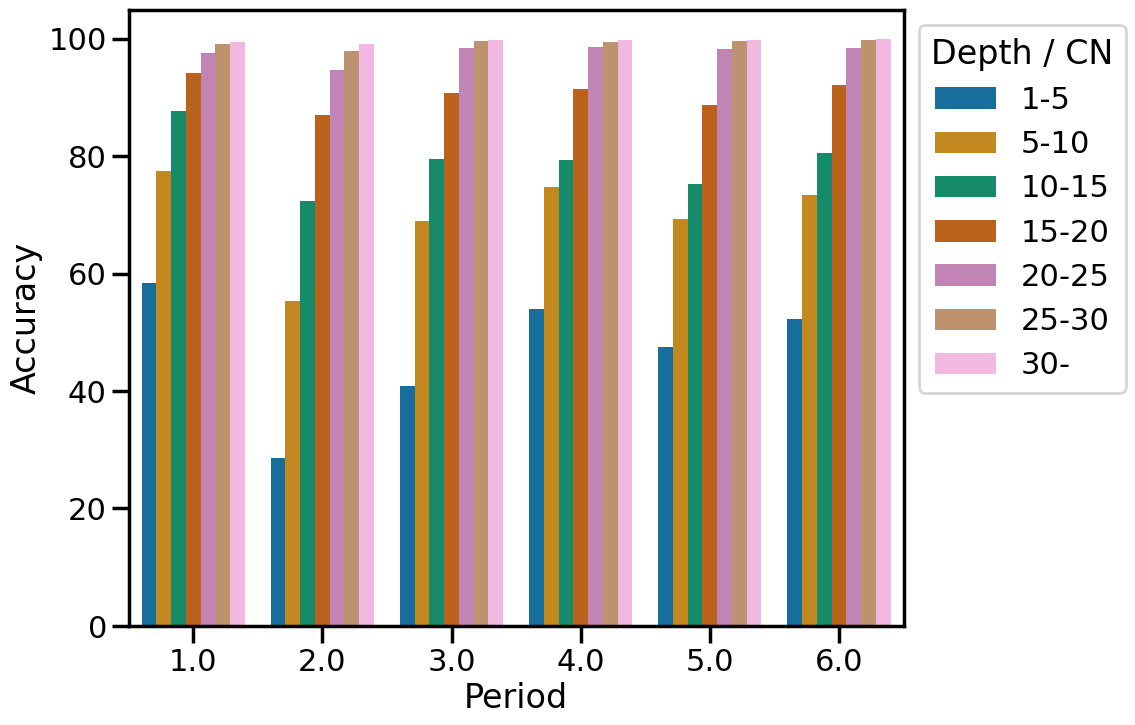

In [21]:
fig = plt.figure(figsize=(10, 8))

ax = sns.barplot(
    df_plot,
    x="period",
    y="accuracy",
    hue="depth",
    palette="colorblind"
)

ax.set(
    xlabel="Period",
    ylabel = "Accuracy"
)

_ = ax.get_legend().set(
    title="Depth / CN",
    bbox_to_anchor = (1, 1)
)

In [22]:
from scipy import ndimage

df_plot_density = (
    df_comparison
        .query("period >= 1 and period <= 6")
        .assign(depth = lambda x: x["depth"] / x["copy_number"])[["match", "period", "depth"]]
)

df_plot_smooth = (
    df_plot_density        
        .drop("period", axis=1)
        .groupby(["depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
smooth = ndimage.gaussian_filter1d(df_plot_smooth["accuracy"], 3, mode="reflect")
df_plot_smooth = df_plot_smooth.assign(smooth = smooth)


df_plot_smooth_period = (
    df_plot_density
        .groupby(["period", "depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
for group, data in df_plot_smooth_period.groupby(["period"]):
    current_smooth = ndimage.gaussian_filter1d(data["accuracy"], 3, mode="reflect")
    smooth.append(current_smooth)
df_plot_smooth_period = df_plot_smooth_period.assign(smooth = np.concatenate(smooth))

df_plot_smooth_period

,period,depth,accuracy,n_obs,smooth
0,1,1.0,0.398346,7737,0.528959
1,1,1.5,0.453389,6683,0.539385
2,1,2.0,0.667052,4322,0.558228
3,1,2.5,0.556924,6737,0.582306
4,1,3.0,0.634470,7682,0.608420
...,...,...,...,...,...
1132,6,126.0,1.000000,1,1.000000
1133,6,140.0,1.000000,1,1.000000
1134,6,147.0,1.000000,1,1.000000
1135,6,160.5,1.000000,1,1.000000


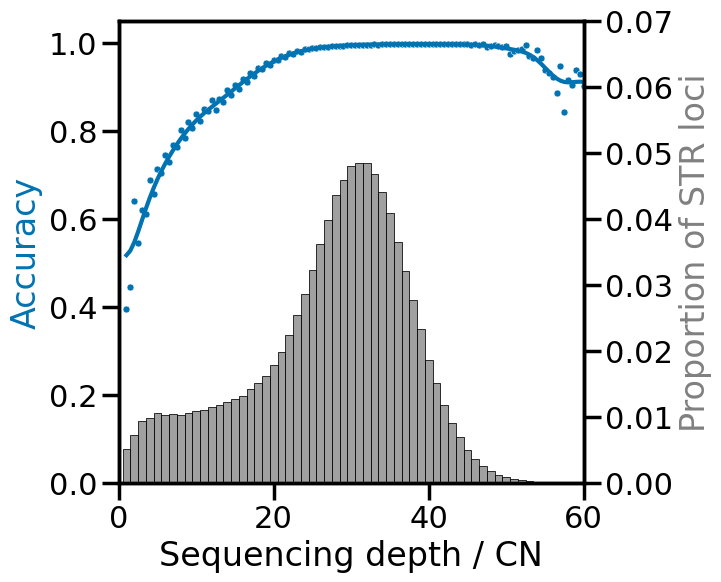

In [23]:
fig = plt.figure(figsize=(6, 6))

ax = sns.lineplot(
    df_plot_smooth.assign(tmp="ConSTRain"), # hack to add a legend
    x = "depth",
    y = "smooth",
    hue="tmp",
    palette="colorblind",
    legend=False
)

ax = sns.scatterplot(
    df_plot_smooth,
    x = "depth",
    y = "accuracy",
    color=sns.color_palette("colorblind")[0],
    s=25,
    ax = ax,
)

ax.set(
    xlabel = "Sequencing depth / CN",
    ylabel = "Accuracy",
    ylim = (0, 1.05),
    xlim = (0, 60)
)
ax.yaxis.label.set_color(color=sns.color_palette("colorblind")[0])

ax2 = ax.twinx()
ax2 = sns.histplot(
    df_plot_density,
    x = "depth",
    discrete=True,
    stat="proportion",
    color="grey",
    ax=ax2,
)
ax2.set(
    ylabel="Proportion of STR loci",
    ylim=(0, 0.07),
)
ax2.yaxis.label.set_color(color="grey")

plt.show()

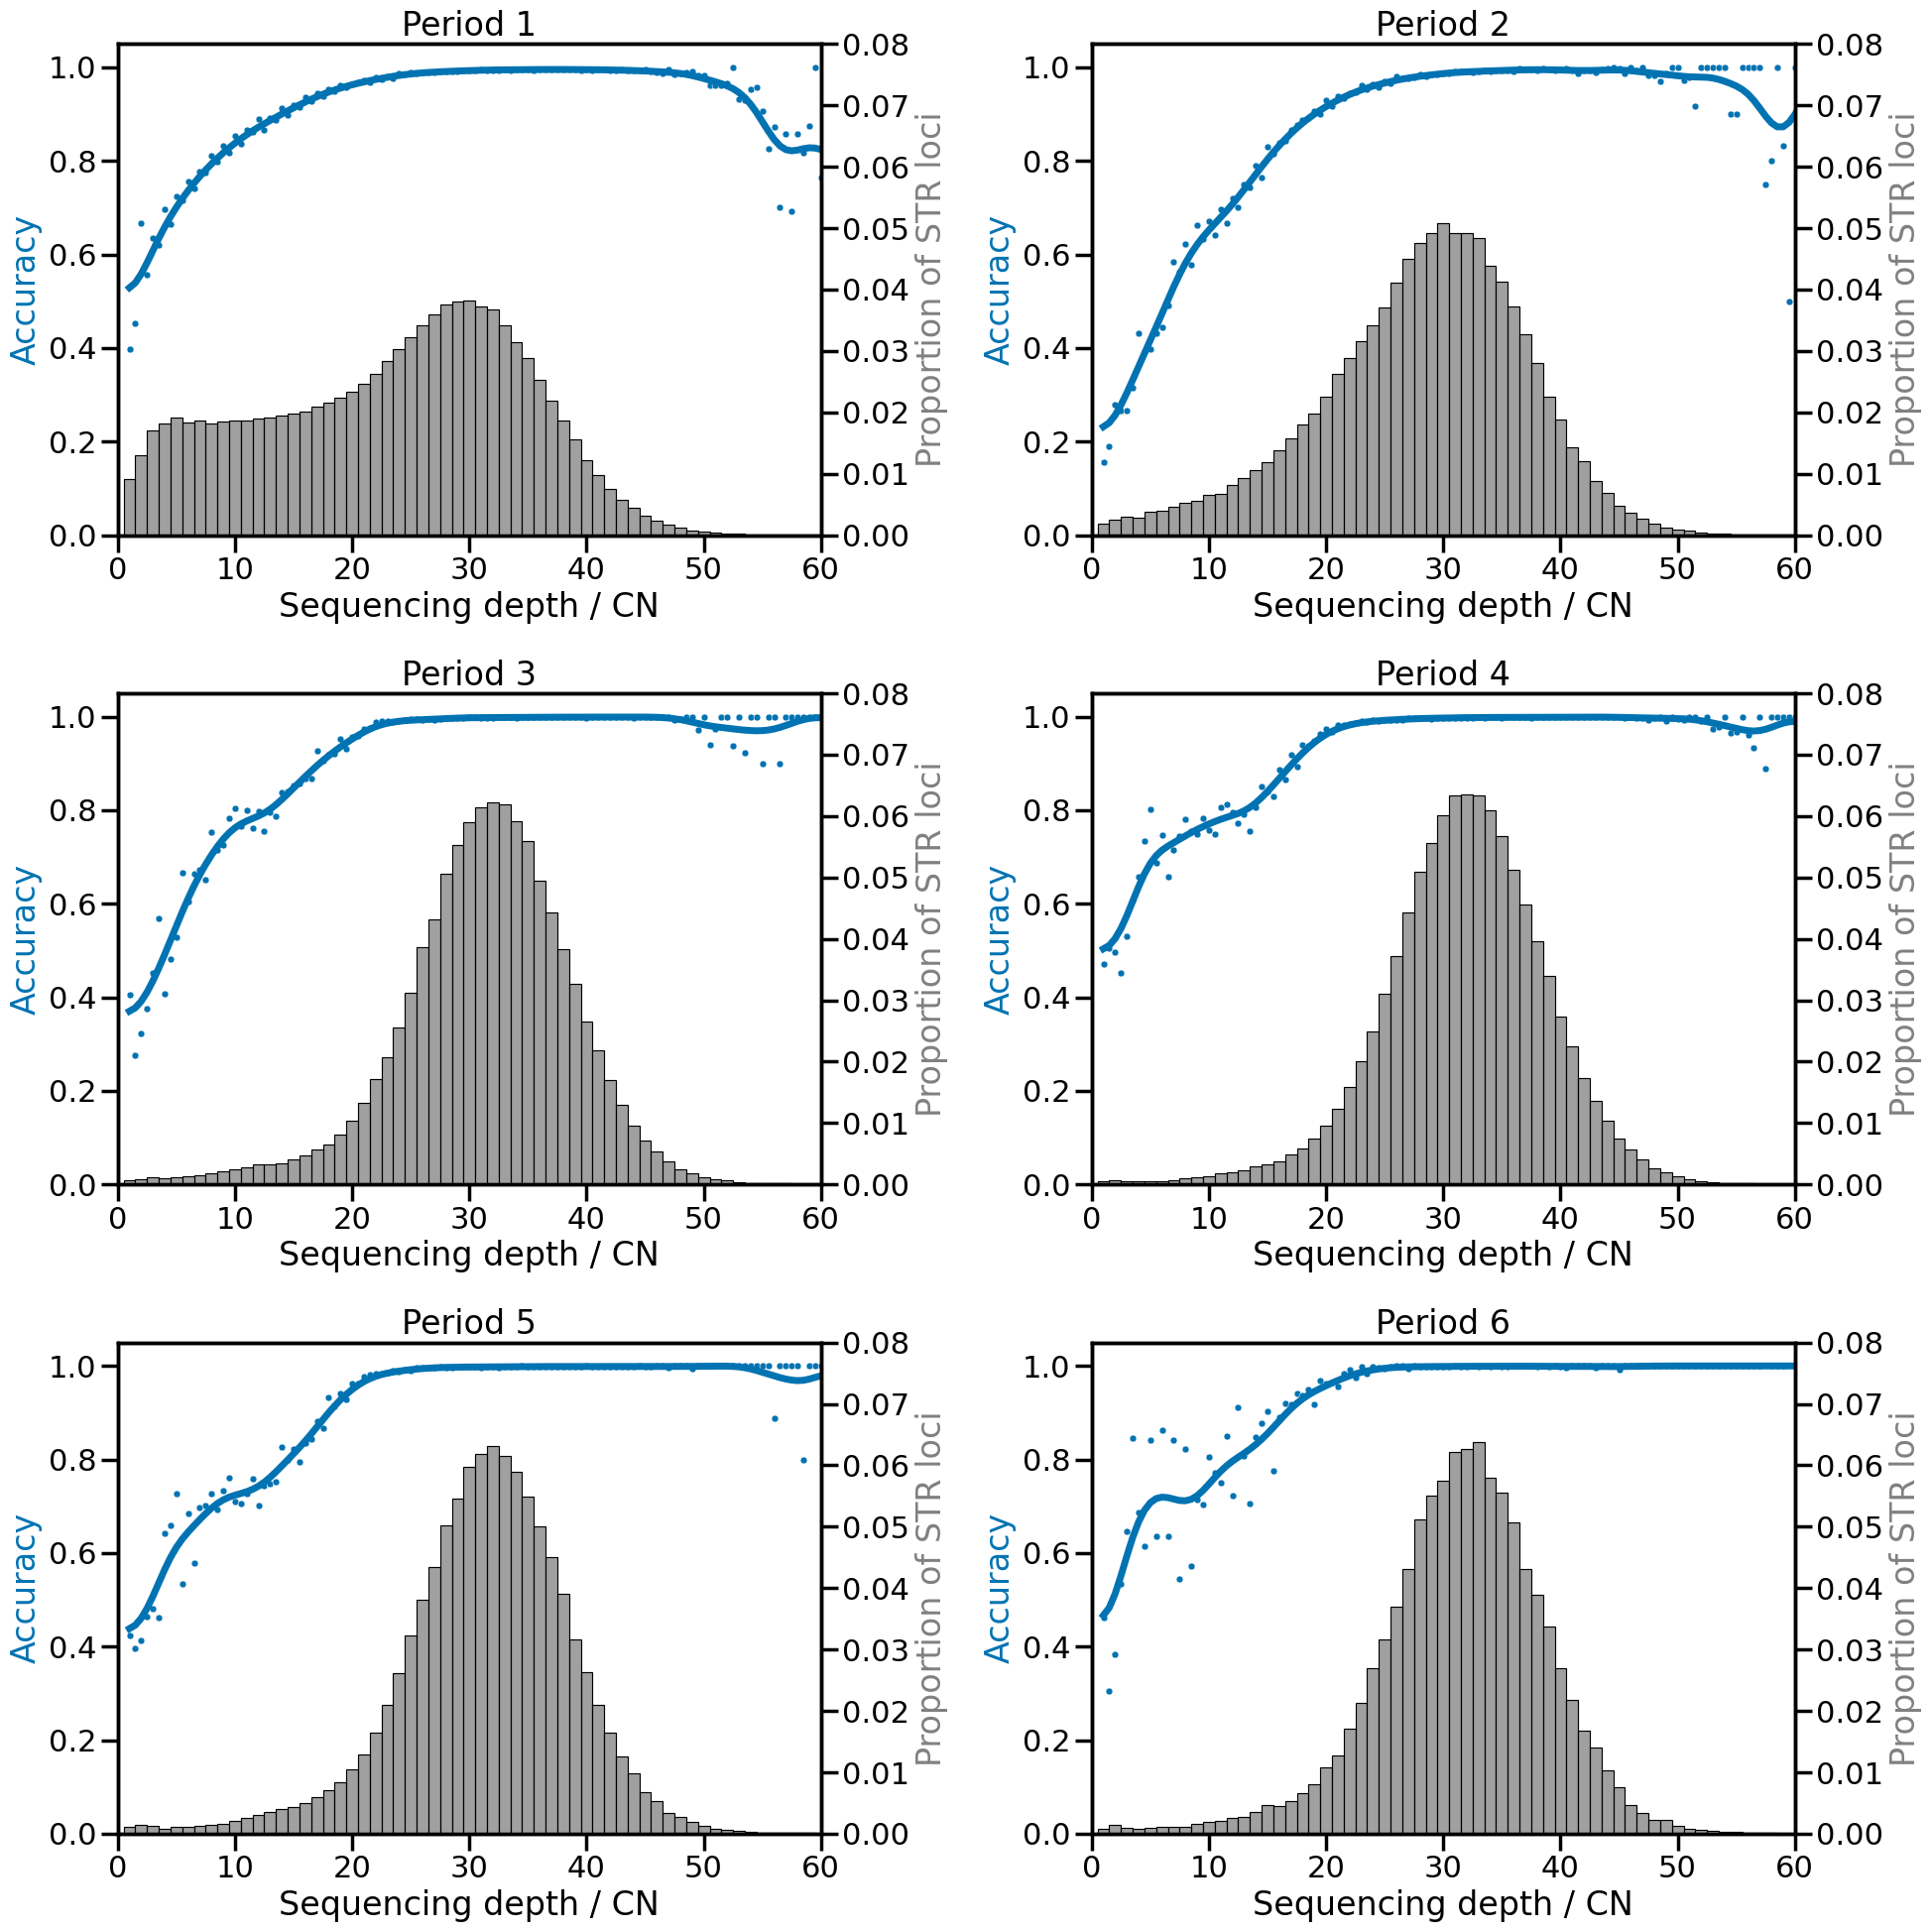

In [24]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

for period, ax in zip(range(1, 7), axes.ravel()):
    df_subplot = (df_plot_smooth_period
                  .query(f"period == {period}"))

    ax = sns.lineplot(
        df_subplot,
        x = "depth",
        y = "smooth",
        color=sns.color_palette("colorblind")[0],
        linewidth=5,
        ax = ax,
    )

    ax = sns.scatterplot(
        df_subplot,
        x = "depth",
        y = "accuracy",
        color=sns.color_palette("colorblind")[0],
        s=25,
        ax = ax,
    )

    ax.set(
        title = f"Period {period}",
        xlabel = "Sequencing depth / CN",
        ylabel = "Accuracy",
        ylim = (0, 1.05),
        xlim = (0, 60)
    )
    ax.yaxis.label.set_color(color=sns.color_palette("colorblind")[0])
    
    ax2 = ax.twinx()
    ax2 = sns.histplot(
        df_plot_density.query(f"period == {period}"),
        x = "depth",
        discrete=True,
        stat="proportion",
        color="grey",
        ax=ax2,
    )
    
    ax2.set(
        ylabel="Proportion of STR loci",
        ylim=(0, 0.08),
    )
    ax2.yaxis.label.set_color(color="grey")

plt.tight_layout()

In [25]:
df_plot_density_p1 = (
    df_comparison
        .query("period == 1")
        .assign(depth = lambda x: x["depth"] / x["copy_number"])[["match", "period", "depth"]]
)

df_plot_smooth_p1 = (
    df_plot_density_p1        
        .drop("period", axis=1)
        .groupby(["depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
smooth = ndimage.gaussian_filter1d(df_plot_smooth_p1["accuracy"], 3, mode="reflect")
df_plot_smooth_p1 = df_plot_smooth_p1.assign(smooth = smooth)

In [26]:
df_plot_density_pg1 = (
    df_comparison
        .query("period > 1")
        .assign(depth = lambda x: x["depth"] / x["copy_number"])[["match", "period", "depth"]]
)

df_plot_smooth_pg1 = (
    df_plot_density_pg1        
        .drop("period", axis=1)
        .groupby(["depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
smooth = ndimage.gaussian_filter1d(df_plot_smooth_pg1["accuracy"], 3, mode="reflect")
df_plot_smooth_pg1 = df_plot_smooth_pg1.assign(smooth = smooth)

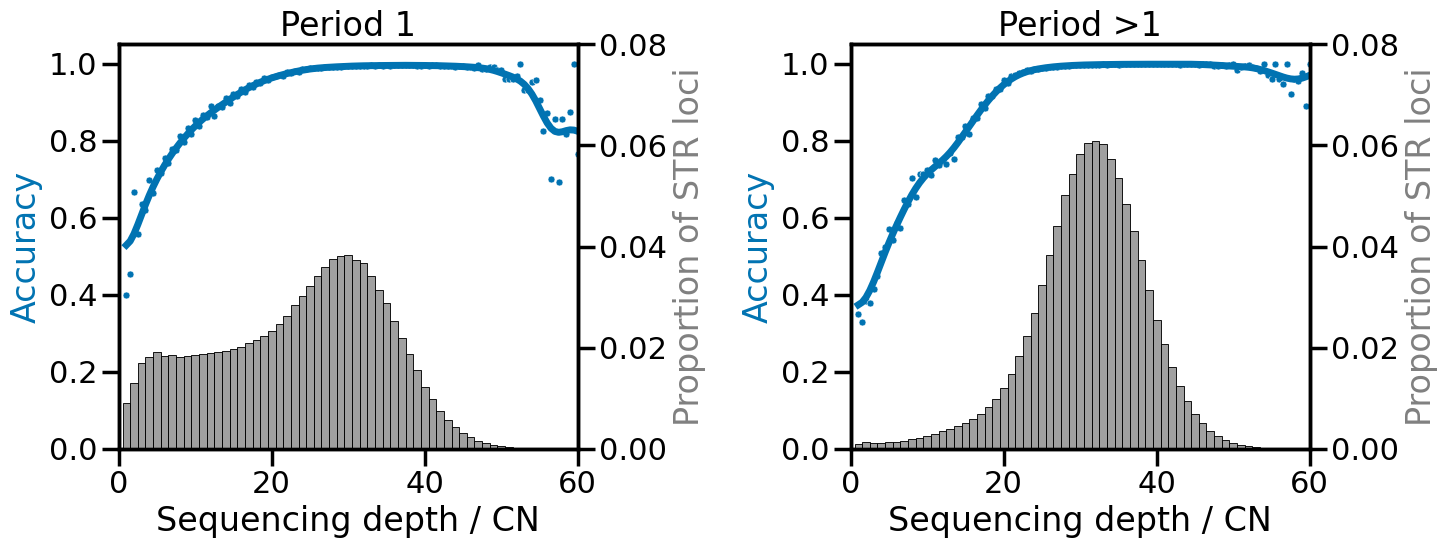

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

ax = sns.lineplot(
    df_plot_smooth_p1,
    x = "depth",
    y = "smooth",
    color=sns.color_palette("colorblind")[0],
    linewidth=5,
    ax = axes[0],
)

ax = sns.scatterplot(
    df_plot_smooth_p1,
    x = "depth",
    y = "accuracy",
    color=sns.color_palette("colorblind")[0],
    s=25,
    ax = ax,
)

ax.set(
    title = "Period 1",
    xlabel = "Sequencing depth / CN",
    ylabel = "Accuracy",
    ylim = (0, 1.05),
    xlim = (0, 60)
)
ax.yaxis.label.set_color(color=sns.color_palette("colorblind")[0])

ax2 = ax.twinx()
ax2 = sns.histplot(
    df_plot_density_p1,
    x = "depth",
    discrete=True,
    stat="proportion",
    color="grey",
    ax=ax2,
)

ax2.set(
    ylabel="Proportion of STR loci",
    ylim=(0, 0.08),
)
ax2.yaxis.label.set_color(color="grey")



ax = sns.lineplot(
    df_plot_smooth_pg1,
    x = "depth",
    y = "smooth",
    color=sns.color_palette("colorblind")[0],
    linewidth=5,
    ax = axes[1],
)

ax = sns.scatterplot(
    df_plot_smooth_pg1,
    x = "depth",
    y = "accuracy",
    color=sns.color_palette("colorblind")[0],
    s=25,
    ax = ax,
)

ax.set(
    title = "Period >1",
    xlabel = "Sequencing depth / CN",
    ylabel = "Accuracy",
    ylim = (0, 1.05),
    xlim = (0, 60)
)
ax.yaxis.label.set_color(color=sns.color_palette("colorblind")[0])

ax2 = ax.twinx()
ax2 = sns.histplot(
    df_plot_density_pg1,
    x = "depth",
    discrete=True,
    stat="proportion",
    color="grey",
    ax=ax2,
)

ax2.set(
    ylabel="Proportion of STR loci",
    ylim=(0, 0.08),
)
ax2.yaxis.label.set_color(color="grey")

plt.tight_layout()